In [1]:
# the tequila library will be used to construct quantum circuits
import tequila as tq
from tequila.wavefunction.qubit_wavefunction import QubitWaveFunction

import numpy as np
from numpy import pi, e

from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import Operator
from qiskit.circuit.exceptions import CircuitError
import qiskit

from math import sqrt, log2
from multipledispatch import dispatch
import jdc
import copy

To impliment quantum hoare logic, we utilize the grammar of quantum programs as defined in [2].  That is, 
```
S ::= skip | q := 0 | q̅ := U q̅ | S 1 ; S 2 | measure M [q̅] : S̅ | while M [q̅] = 1 do S
```
For more details about the specifics of this syntax, see [1].

In [2]:
# define a class structure for quantum programs using the syntax of quantum hoare logic
class QProgram:
    def skip(): # skip operation does nothing
        pass
    
    def __init__(self, q̅=[[1, 0]], backend=None):
        if hasattr(np.shape(q̅), '__len__') and len(np.shape(q̅)) > 1:
            self.q̅ = np.array(1) # register statevector
            for qubit in q̅:
                self.q̅ = np.kron(self.q̅, qubit)
        else:
            self.q̅ = q̅ # quantum register
            
        self.instructions = [] # list of instructions (operations) carried out by the program
            
        self.num_qubits = int(log2(len(self.q̅)))
        
        
        self.M_k = [] # list of terminating operations of the program as Kraus operators M_k
        
        self.backend = backend
        
    def assign(self, U, variables): # function corresponding to q:=Uq or q̅:=Uq̅
        self.instructions.append((U, variables))

The methods of the `QProgram` class defined so far encode the first three components of a quantum program:
```
skip | q := 0 | q̅ := U q̅
```
The `skip` method does nothing, the constructor corresponds to setting the initial states of individual qubits, ie. `q := 0`, and the `assign` method corresponds to applying a unitary operator to a set of qubits, ie. `q̅ := U q̅`.

In [3]:
    %%add_to QProgram
    def to_circuit(self, framework='tequila'): # method to return a quantum circuit defined in tequila or qiskit from the current QProgram object
        if framework == 'tequila':
            qc = tq.QCircuit()
            
            qc_initializer = tq.QCircuit()
            initializer = QuantumCircuit(self.num_qubits) # create an initializer circuit in qiskit before converting it to tequila
            for i in range(self.num_qubits):
                # make sure qubit is initialized on tequila circuit if it remains in state [1, 0]
                qc_initializer += tq.gates.u3(0, 0, 0, i)
            initializer.initialize(self.q̅, range(self.num_qubits))

            transpiled = transpile(initializer, basis_gates=['cx', 'u3']) # convert to qiskit through open qasm
            qasm = transpiled.qasm()
            for instruction in qasm.split('\n'):
                if instruction[:2] == 'u3':
                    ϴ, φ, λ = map(eval, instruction.replace('u3', '').replace('pi', str(pi)).split(' ')[0].replace('(', '').replace(')', '').split(','))
                    q = list(map(int, instruction.replace(';', '').replace('q', '').replace('[', '').replace(']', '').split(' ')[1].split(',')))
                    qc_initializer += tq.gates.u3(theta=ϴ, phi=φ, lambd=λ, target=q)
                elif instruction[:2] == 'cx':
                    q = list(map(int, instruction.replace(';', '').replace('q', '').replace('[', '').replace(']', '').split(' ')[1].split(',')))
                    qc_initializer += tq.gates.CX(control=q[0], target=q[1])
            qc += qc_initializer
            
        elif framework == 'qiskit':
            qc = QuantumCircuit(self.num_qubits)
            
            qc_initializer = QuantumCircuit(self.num_qubits)
            qc_initializer.initialize(self.q̅, range(self.num_qubits))
            qc += qc_initializer
            
        for instruction in self.instructions:
            variables = instruction[1]
            U = instruction[0]
            
            gate_circuit = QuantumCircuit(self.num_qubits)
            gate_circuit.unitary(U, variables)
            transpiled = transpile(gate_circuit, basis_gates=['cx', 'u3']) # for each assignment instruction, reduce the corresponding unitary operation to cx and u3 gates
            
            if framework == 'tequila':
                # get the qiskit gate in open qasm
                qasm = transpiled.qasm()
                for instruction in qasm.split('\n'):
                    if instruction[:2] == 'u3':
                        ϴ, φ, λ = map(eval, instruction.replace('u3', '').replace('pi', str(pi)).split(' ')[0].replace('(', '').replace(')', '').split(','))
                        q = list(map(int, instruction.replace(';', '').replace('q', '').replace('[', '').replace(']', '').split(' ')[1].split(',')))
                        qc += tq.gates.u3(theta=ϴ, phi=φ, lambd=λ, target=q)
                    elif instruction[:2] == 'cx':
                        q = list(map(int, instruction.replace(';', '').replace('q', '').replace('[', '').replace(']', '').split(' ')[1].split(',')))
                        qc += tq.gates.CX(control=q[0], target=q[1])
            elif framework == 'qiskit':
                qc += transpiled
                
        return qc
    
    def to_unitary(self): # method to return the instructions as a single unitary matrix
        qc = QuantumCircuit(len(self.q̅))
        for instruction in self.instructions:
            variables = instruction[1]
            u = instruction[0]
            qc.unitary(u, variables) # map the program to a quantum circuit
        U = Operator(qc).data # get the corresponding unitary matrix
        return U

The `to_circuit` method can be used to generate a quantum circuit from the current `QProgram` object, in the form of either a qiskit `QuantumCircuit` or a tequila `QCircuit`.  The `to_unitary` method can be used to generate a unitary operator corresponding to the current `QProgram` object.  This allows us to test our progress so far:

In [4]:
# testing QProgram class using to_circuit
S = QProgram(q̅=[[1,0],[0,1],[0,1],[1,0]]) # initial register state 0, 1, 1, 0

In [5]:
# define some quantum gates as unitary operators
CNOT = np.array([[1,0,0,0],[0,0,0,1],[0,0,1,0],[0,1,0,0]]) # controlled not gate
H = np.array([[1/sqrt(2), 1/sqrt(2)],[1/sqrt(2), -1/sqrt(2)]]) # hadamard gate
T = np.array([[1, 0], [0, e**(1j*pi/4)]]) # T gate

In [6]:
# assign the operations to the register

S.assign(H, [0])
S.assign(T, [0])
S.assign(H, [0])

S.assign(H, [2])

S.assign(CNOT, [1,3])
S.assign(CNOT, [0,2])

In [7]:
# generate qiskit circuit using the tequila framework to return a tequila.QCircuit object
qc = S.to_circuit(framework='tequila')

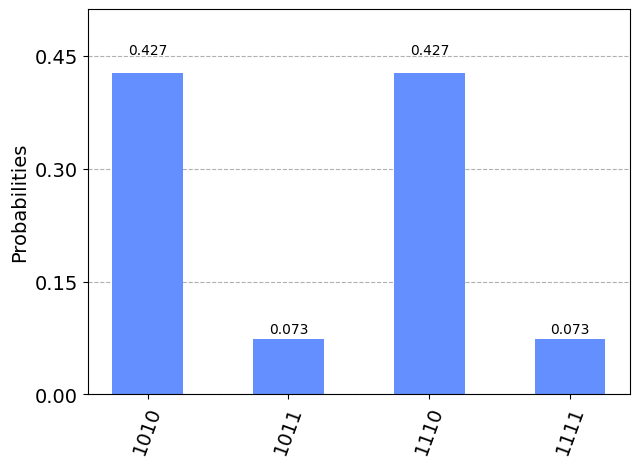

In [8]:
# simulate the circuit
wfn = tq.simulate(qc)

# get the output probabilities from the probability amplitudes
counts = dict()
for key, value in wfn.state.items():
    counts[key.binary[::-1]] = value * np.conj(value)
    
# plot the output
from qiskit.tools.visualization import plot_histogram
plot_histogram(counts)

In [9]:
# generate qiskit circuit using the qiskit framework to return a qiskit.QuantumCircuit object
qc = S.to_circuit(framework='qiskit')

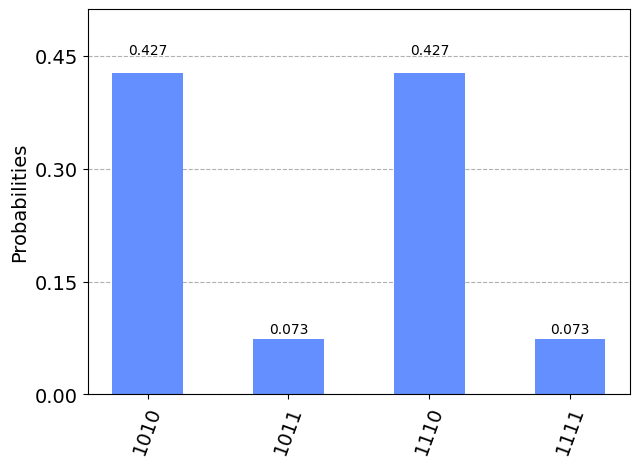

In [10]:
# simulate the circuit
from qiskit import Aer, execute
from qiskit.compiler import assemble

# run the quantum circuit on a statevector simulator backend
qobj = assemble(qc)
backend = Aer.get_backend('statevector_simulator')

# create a Quantum Program for execution
result = backend.run(qobj).result()

# plot the output
plot_histogram(result.get_counts(qc))

Below is an example of how to impliment the `measure M [q̅] : S̅` and  `while M [q̅] = 1 do S` components of a quantum program.

### `QProgram.measurement` 
This method takes arguments for the qubits to be measured, and returns the result of the measurement.  In addition to this, the function modifies the state of the register to be the state after wavefunction collapse, and clears the previous instructions (reflecting that measurements are non unitary).

### `QProgram.while_loop_body`
This method corresponds to applying a sub algorithm to the quantum register while a specified qubit is measured to be equal to a specified classical bit.  This is done using the principle or deferred measurements.  In other words, the sub algorithm is treated as a controlled gate added to the instructions with the control qubit being the passed loop conditional qubit.  The gate is applied repeatedly until the probability of the loop conditional being true is less than an arbitrary threshold (or until some maximum number of iterations is reached). 

In [17]:
    %%add_to QProgram
    def measure(self, q_m): # function corresponding to measuring a set of qubits
        # returns the result of the measurement and modifies the instructions so that they map the initial state to the state after the measurement
        
        # run the program and get the output as a statevector
        qc = self.to_circuit(framework='tequila')
        if self.backend != None:
            state = tq.simulate(qc, backend=backend)
            measurement = tq.simulate(qc, samples=1, read_out_qubits=q_m, backend=backend).state
        else:
            state = tq.simulate(qc)
            measurement = tq.simulate(qc, samples=1, read_out_qubits=q_m).state
            
        res = list(measurement.keys())[0] # get the collapsed state of the qubit
        
        valid_basis = dict() # dictionary of valid basis states given the measured value of q_m
        norm_sum = 0 # stores the sum of each valid probability amplitude times its conjugate so the calculated state can be normalized
        for key in state.state.keys():
            # check if the bits in the binary form of this basis corresponding to the qubits being measured are equal to the measured states
            if all([('{:0'+str(self.num_qubits)+'d}').format(int(format(int(key), 'b')))[q_m[i]] == str(res[i]) for i in range(len(q_m))]):
                valid_basis[key] = state.state[key]
                norm_sum += (state.state[key]*np.conj(state.state[key]))
                
        # normalize the new vector
        for key in valid_basis.keys():
            valid_basis[key] *= sqrt(1/norm_sum)
            
        # convert the valid_basis dict into a statevector array
        final_state = QubitWaveFunction(valid_basis, self.num_qubits).to_array()
        
        # replace the quantum register with the final state and clear the instructions (reflecting that measurements are non unitary)
        self.q̅ = final_state
        self.instructions = []
        
        return ('{:0'+str(len(q_m))+'d}').format(int(format(int(res), 'b'))) # return the measured state
        
    def while_loop_body(self, q_m, expected_measurement : str, sub_algorithm, prob_threshold=0.01, iter_cutoff=10):
        n = 1 # keeps track of prob of each loop iteration
        iters = 0
        program = self # run the initial program before entering the loop body
        
        # make sure sub_algorithm has the same number of variables as the current program
        if self.num_qubits != program.num_qubits:
            raise ValueError('the passed sub_algorithm has a quantum register with a different length of the current program')
        
        # create a unitary from the sub_algorithm by having each instruction controlled by the qubits in q_m
        circuit_instructions = sub_algorithm.to_circuit(framework='qiskit').data
        sub_algorithm_circuit = QuantumCircuit(self.num_qubits)
        for instruction in circuit_instructions:
            if instruction.operation.name == 'initialize':
                continue # skip over initialization instruction
            try:
                gate = instruction.operation.definition.control(len(q_m)) # controlled instruction
                    
                for qubit in range(len(q_m)):
                    if expected_measurement[qubit] == '0': # flip qubits that are expected to be 0
                        sub_algorithm_circuit.x(q_m[qubit])
                            
                sub_algorithm_circuit.append(gate, q_m + [q for q in list(instruction.qubits)])
                    
                for qubit in range(len(q_m)):
                    if expected_measurement[qubit] == '0':
                        sub_algorithm_circuit.x(q_m[qubit])
                    
            except (CircuitError, ValueError):
                raise ValueError('an instruction was applied to one of the control qubits in the sub algorithm')
        # calculate the unitary of the sub algorithm
        U = Operator(sub_algorithm_circuit).data
        
        # final state that is returned after the loop is carried out
        final_state = self.q̅
        
        while(n > prob_threshold and iters < iter_cutoff):
            # get the probability of the qubits in q_m being equal to the expected_measurement
            qc = program.to_circuit(framework='tequila')
            
            if self.backend != None:
                state = tq.simulate(qc, backend=backend)
            else:
                state = tq.simulate(qc)
                
            # get the prob from the prob amplitudes of basis components satisfying the conditional
            prob = 0
            for key in state.state.keys():
                # check if the bits in the binary form of this basis corresponding to the qubits being measured are equal to the measured states
                if all([('{:0'+str(self.num_qubits)+'d}').format(int(format(int(key), 'b')))[q_m[i]] == str(expected_measurement[i]) for i in range(len(q_m))]):
                    prob += abs(state.state[key]*np.conj(state.state[key]))
            n *= prob # update the conditional prob
             
            program = copy.deepcopy(sub_algorithm) # update the sub algorithm
            program.q̅ = state.to_array() # update the sub algorithm's register to the state after this many interations
            
            # modify all operations applied within the sub algorithm (ie. 'program') to be controlled according to the loop conditional
            program.instructions = []
            self.assign(U, range(self.num_qubits)) # add the unitary for this step to the list of instructions     
            iters += 1
            
            # update final_state
            final_state = state.to_array()
        
        return final_state

In [12]:
# testing the measure operation
S.measure([0, 1])

'01'

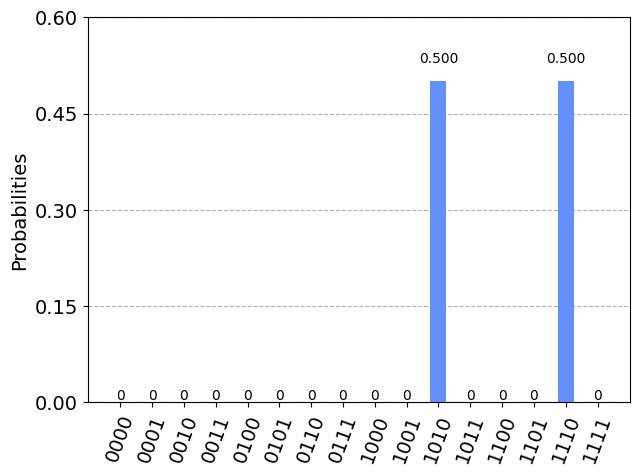

In [13]:
final_state = S.q̅ # get the state of the register after the measurement was performed

# get the output probabilities from the final state to verify that it works as expected
counts = dict()
for i in range(len(final_state)):
    value = final_state[i]
    key = ('{:04d}').format(int(format(int(i), 'b')))
    counts[key[::-1]] = value * np.conj(value)
                               
plot_histogram(counts)

In [18]:
# testing the while_loop_body operation
S = QProgram(q̅=[[0,1],[0,1]])
S.assign(H, [0])
S.assign(H, [1]) # put the two qubits in a superposition

sub_algorithm = QProgram(q̅=[[0,1],[0,1]]) # define a sub algorithm that applies an X gate while qubit 0 is measured to be 1
X = np.array([[0, 1], [1, 0]])
sub_algorithm.assign(X, [1])

S.while_loop_body([0], '1', sub_algorithm)

array([ 1.38777878e-16+0.5j,  0.00000000e+00-0.5j, -5.55111512e-17-0.5j,
        0.00000000e+00+0.5j])

Quantum Hoare triples can be expressed as $\{Q\}S\{P\}$, where the precondition $P$ and postcondition $Q$ are quantum predicates represented by physical observables (ie. Hermitian matricies).  The partial correctness of a quantum program with respect to these predicates is defined as
$$
\models_{par} \{Q\}S\{P\} ↔ (∀ \text{ quantum states } ρ), \text{ } tr(Pρ) ≤ tr(Q⟦S⟧(ρ)) + tr(ρ) − tr(⟦S⟧(ρ)) 
$$
and the total correctness is defined as
$$
\models_{tot} \{Q\}S\{P\} ↔ (∀ \text{ quantum states } ρ), \text{ } tr(Pρ) ≤ tr(Q⟦S⟧(ρ))
$$
where $⟦S⟧$ is the super-operator form of quantum program $S$ [1].  

In effect, these definitions state that a quantum program ($S$) is correct if and only if it causes the expectation value of all possible states ($ρ$) with respect to a postcondition observable ($Q$) to be greater than or equal to the expectation value of the original state with respect to a precondition observable ($P$).

In order to prove the correctness of a quantum program, we are interested in being able to find the *weakest liberal precondition* (wlp) of a quantum program $S$ with respect to a given quantum predicate $P$, denoted by $wlp.S.P$ [1].  This is the weakest quantum predicate $Q$ satisfying $\models_{par} \{Q\}S\{P\}$.  A proof of correctness involves starting from the postcondition $Q$, and solving for $wlp.S.Q$, called $P'$.  It then suffices to show that $P⊑P'$ (where $⊑$ deno

### Sources
1. Liu, T., Li, Y., Wang, S., Ying, M., & Zhan, N. (2016). A Theorem Prover for Quantum Hoare Logic and Its Applications. doi:10.48550/ARXIV.1601.03835
2. Ying, M. (2012). Floyd--Hoare Logic for Quantum Programs. ACM Trans. Program. Lang. Syst., 33(6). doi:10.1145/2049706.2049708
3. D'Hondt, E., & Panangaden, P. (2006). Quantum weakest preconditions. Mathematical Structures in Computer Science, 16, 429 - 451. 
4. N Ielsen, I. L. & Chuang, M. A. 2000. Quantum Computation and Quantum Information. Cambridge University Press, Cambridge, UK.
5. S Elinger , P. 2004. Towards a quantum programming language. Math. Structures Comput. Sci.